# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

In [33]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [34]:
import abc

class BaseLoss(abc.ABC):
    """Базовый класс лосса"""
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [35]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        weighted_X = np.dot(X, w)
        loss = (np.linalg.norm(weighted_X - y)**2) / X.shape[0]
        return loss
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        weighted_X = np.dot(X, w)
        grad = 2 * np.dot(X.T, (weighted_X - y)) / X.shape[0]
        return grad

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [36]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [37]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 10000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    weights = [w_init] * n_iterations
    for iteration in range(1, n_iterations):
        w_init = w_init - lr * loss.calc_grad(X, y, w_init)
        weights[iteration] = w_init
    return weights
    

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [38]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [39]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045026
0.8670644395649649


In [40]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Ответ: для того, чтобы на графиках была заметна динамика, в параметры я передала небольшое число итераций (100) и диапазон шага, начиная от 0,0001 (маленький). Теперь можно заметить связь: когда длина шага очень маленькая, количества итераций может быть недостаточно для того, чтобы дойти до оптимума, хоть траектория и получается довольно направленной. Напротив, со слишком большим шагом спуск нестабильный и есть риск (небольшой) переступить через оптимум. Оптимальная величина шага - это скорее большой, чем маленький, но при котором градиентный спуск сходится. 

Длина шага:  0.002602603729570859


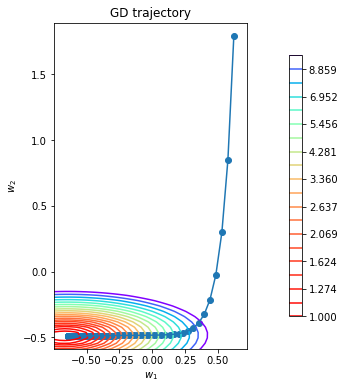

Длина шага:  0.004312239125131053


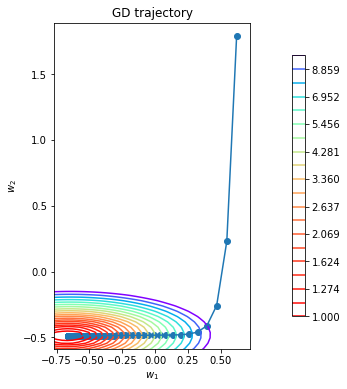

Длина шага:  0.004710680378340554


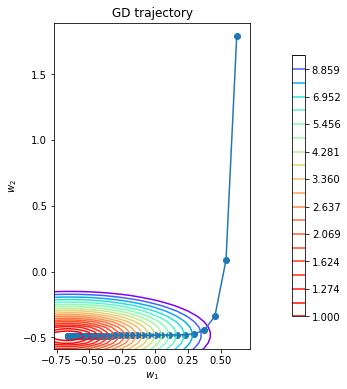

Длина шага:  0.004812876116719604


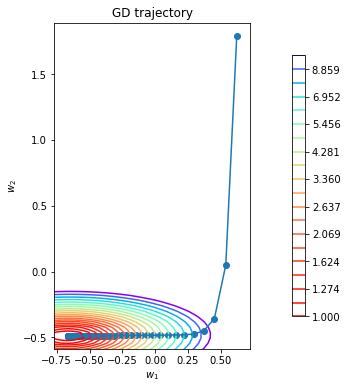

Длина шага:  0.005701359961123188


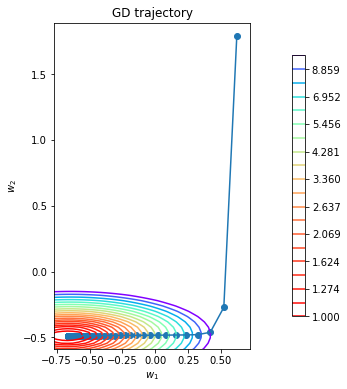

In [41]:
lrs = np.sort(np.random.uniform(0.0001, 0.01, 5))
loss = MSELoss()
for lr in lrs:
    w_list = gradient_descent(w_init, X, y, loss, lr, 100)
    print("Длина шага: ", lr)
    plot_gd(w_list, X, y, loss)

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [42]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    weights = [w_init] * n_iterations
    for iteration in range(1, n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init =  w_init - lr * loss.calc_grad(batch, y_batch, w_init)
        weights[iteration] = w_init
    return weights

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

Ответ: SGD намного более нестабильный, в отличие от GD, потому что на каждой итерации он работает не с одной и той же выборкой, а со случайной частью данных, направления градиента на которой может отличаться от общей выборки. Отсюда исходит первый вывод: чем больше размер подвыборки, тем более стабильной является траектория, потому что большая подвыборка более приближена к общей выборке. Из-за нестабильности траектории SGD большая длина шага означает больший риск пропустить оптимум, и зачастую SGD "блуждает" именно у точки около оптимума. На мой взгяд, в SGD лучше ставить длину шага поменьше. 

Длина шага:  0.0021913906201590193 
 Размер подвыборки:  58


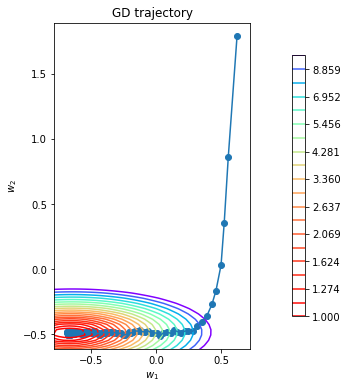

Длина шага:  0.0021913906201590193 
 Размер подвыборки:  122


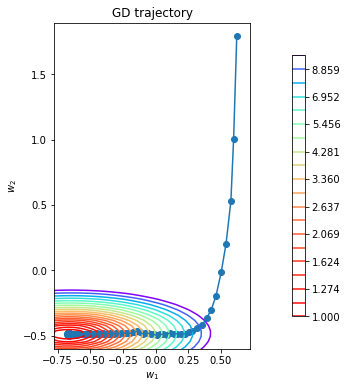

Длина шага:  0.0021913906201590193 
 Размер подвыборки:  157


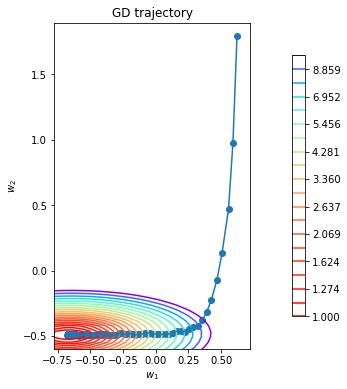

Длина шага:  0.0021913906201590193 
 Размер подвыборки:  160


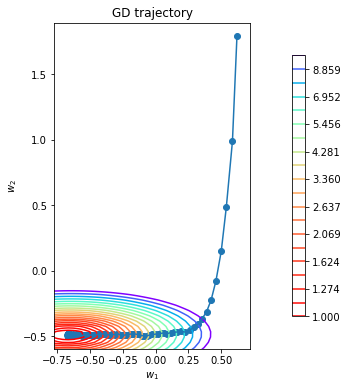

Длина шага:  0.0039637183463551474 
 Размер подвыборки:  58


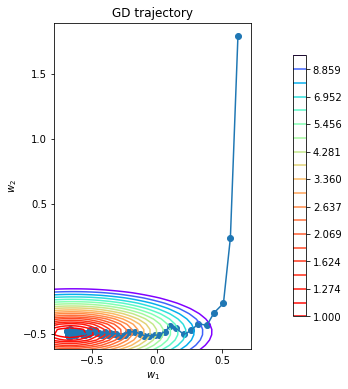

Длина шага:  0.0039637183463551474 
 Размер подвыборки:  122


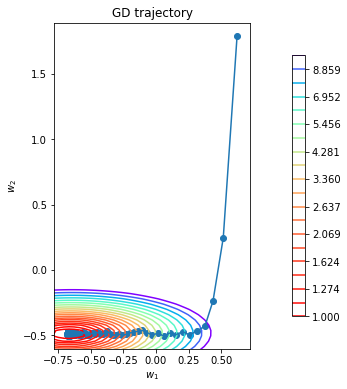

Длина шага:  0.0039637183463551474 
 Размер подвыборки:  157


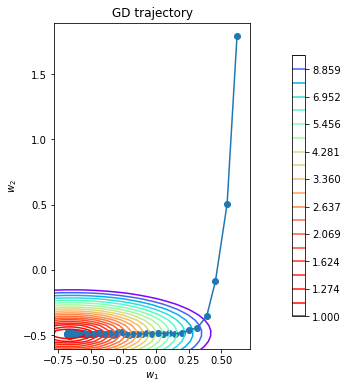

Длина шага:  0.0039637183463551474 
 Размер подвыборки:  160


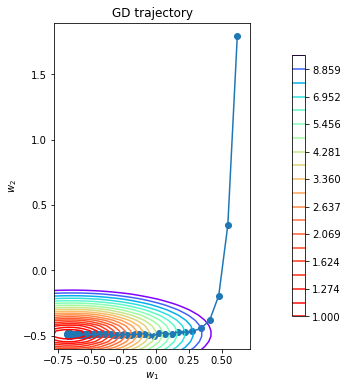

Длина шага:  0.005625339763941128 
 Размер подвыборки:  58


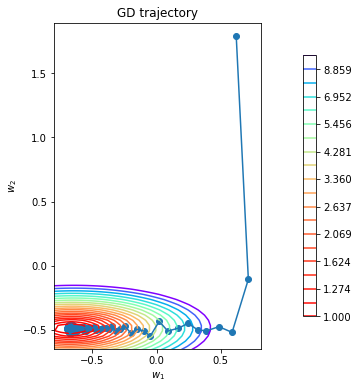

Длина шага:  0.005625339763941128 
 Размер подвыборки:  122


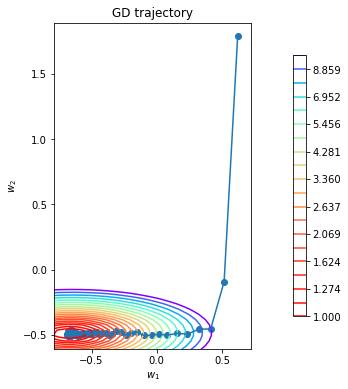

Длина шага:  0.005625339763941128 
 Размер подвыборки:  157


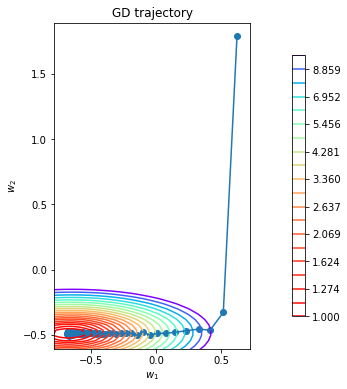

Длина шага:  0.005625339763941128 
 Размер подвыборки:  160


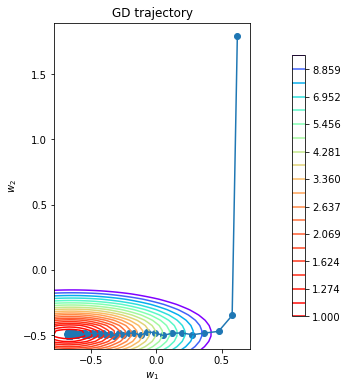

Длина шага:  0.00891814837856587 
 Размер подвыборки:  58


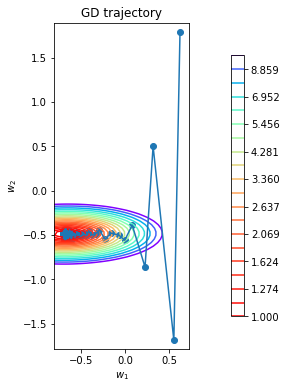

Длина шага:  0.00891814837856587 
 Размер подвыборки:  122


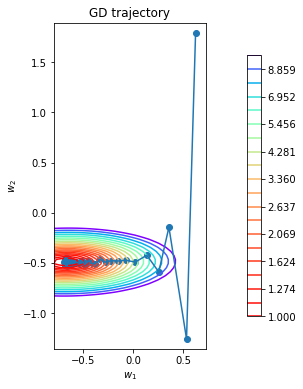

Длина шага:  0.00891814837856587 
 Размер подвыборки:  157


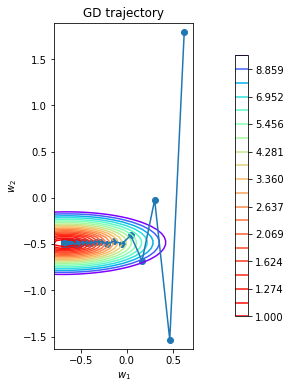

Длина шага:  0.00891814837856587 
 Размер подвыборки:  160


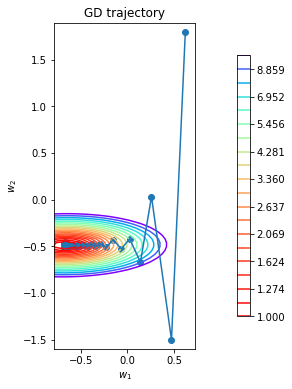

In [43]:
lrs = np.sort(np.random.uniform(0.001, 0.01, 4))
batch_sizes = np.sort(np.random.randint(10, 200, 4))
loss = MSELoss()
for lr in lrs:
    for batch_size in batch_sizes:
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, 1000)
        print("Длина шага: ", lr, '\n', "Размер подвыборки: ", batch_size)
        plot_gd(w_list, X, y, loss)

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [44]:
def new_stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    weights = [w_init] * n_iterations
    s_0 = 1
    lr_init = lr
    for iteration in range(1, n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batch = X[batch_indices]
        y_batch = y[batch_indices]
        lr = lr_init * np.power(s_0 / (s_0 + iteration), p)
        w_init =  w_init - lr * loss.calc_grad(batch, y_batch, w_init)
        weights[iteration] = w_init
    return weights

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

Ответ: чем меньше значение p, тем менее интенсивнее уменьшается длина шага. По графикам видно, что при маленьких значениях параметра (и маленьком уменьшении шагов соответственно) SGD "блуждает" у оптимума, потому что длину шага нужно было уменьшить больше. Наоборот, при больших значениях параметра (и более эффективном уменьшении шага) траектория спуска через некоторое число итераций становится более стабильной, но в конечном счёте длины шагов становятся настолько маленькими, что количества итераций может не хватить, чтобы дойти до оптимума. 

Значение параметра:  0.41178448990650396


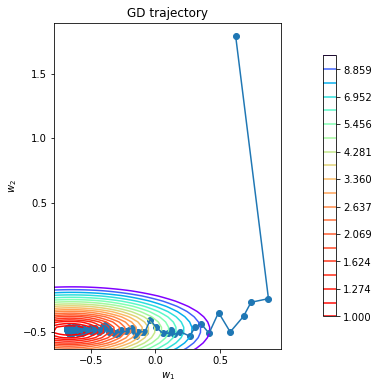

Значение параметра:  0.4310280076153705


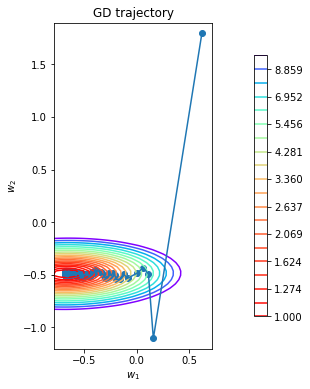

Значение параметра:  0.4386125730148781


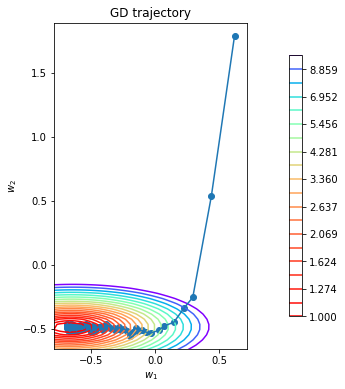

Значение параметра:  0.4770659149997396


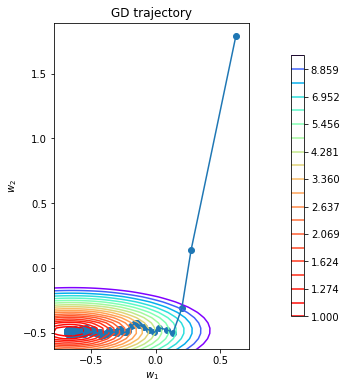

Значение параметра:  0.6395176595613683


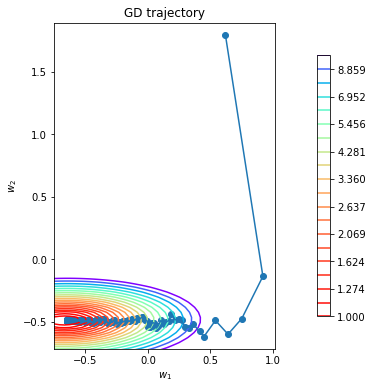

In [45]:
ps = np.sort(np.random.uniform(0.1, 0.7, 5))
loss = MSELoss()
for p in ps:
    w_list = new_stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, p, 1000)
    print("Значение параметра: ", p)
    plot_gd(w_list, X, y, loss)

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

Ответ: на графике не видно преимущества SGD. Визуально можно сделать вывод, что GD достигает асимтоту (минимальное значение лосса) за меньшее количество итераций, тем не менее у SGD есть преимущество, которое нельзя увидеть на графике - каждая итерация SGD выполняется быстрее в 30 раз (размер выборки/размер батча), чем у обычного GD, поэтому его и используют для оптимизации процесса.

Text(0.5, 1.0, 'Loss dynamics')

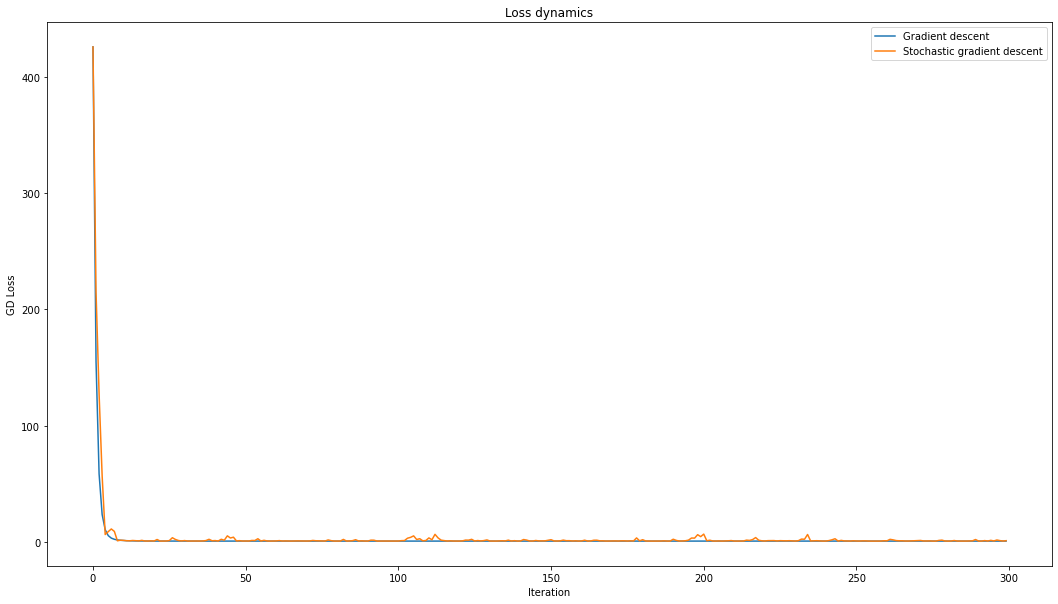

In [46]:
loss = MSELoss()
np.random.seed(7)
n_iterations = 300
gd_losses = np.array([])
sgd_losses = np.array([])
gd_w_list = gradient_descent(w_init, X, y, loss, 0.01, n_iterations)
sgd_w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, n_iterations)
for weight in gd_w_list:
    gd_losses = np.append(gd_losses, loss.calc_loss(X, y, weight))
for weight in sgd_w_list:
    sgd_losses = np.append(sgd_losses, loss.calc_loss(X, y, weight))
plt.figure(figsize = (18, 10))
plt.plot(np.arange(n_iterations), gd_losses, label = 'Gradient descent')
plt.plot(np.arange(n_iterations), sgd_losses, label = 'Stochastic gradient descent')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('GD Loss')
plt.title('Loss dynamics')

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [47]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        
        w_init = np.random.uniform(-2, 2, X.shape[1])
        w_list = gradient_descent(w_init, X, y, self.loss, self.lr, n_iterations)
        self.w = w_list[-1]
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        
        preds = np.dot(X, self.w)
        return preds

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [48]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [49]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", 
    header=None,
    na_values=["?"]
)
X_raw = X_raw[~X_raw[25].isna()].reset_index(drop = True)

In [50]:
pd.set_option('display.max_rows', None)
X_raw

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.00,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.00,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.00,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.00,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.00,115.0,5500.0,18,22,17450.0
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.50,110.0,5500.0,19,25,15250.0
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.50,110.0,5500.0,19,25,17710.0
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.50,110.0,5500.0,19,25,18920.0
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.30,140.0,5500.0,17,20,23875.0
9,2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.80,101.0,5800.0,23,29,16430.0


In [51]:
X_raw.describe()
X_raw.isnull().sum()
# пропуски есть в 1, 5, 18, 19, 21 и 22 столбцах, категориальные переменные - в 2-8, 14, 15, 17 столбцах.

0      0
1     37
2      0
3      0
4      0
5      2
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     4
19     4
20     0
21     2
22     2
23     0
24     0
25     0
dtype: int64

In [52]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [53]:
# поскольку все значения столбцов с пропусками являются вещественными, для заполнения пропусков можно использовать среднее
X_cont_NaN = X_raw[[1, 18, 19, 21, 22]].fillna(X_raw[[1, 18, 19, 21, 22]].mean())

# среди категориальных признаков (в 5 столбце) пропущено только 2 значения, поэтому я заменю пропуски на пустую строку
(X_raw[[5]] == 'four').sum()
X_cat_NaN = X_raw[[5]].fillna('4')

# датасет без пропусков
X = pd.concat([X_raw[[0]], X_cont_NaN[[1]], X_raw[[2, 3, 4]], X_cat_NaN, X_raw[X_raw.columns[6:18]], X_cont_NaN[[18, 19]], X_raw[[20]], X_cont_NaN[[21, 22]], X_raw[[23, 24]]], axis = 1)

# кодировка категориальных переменных фиктивными
X = pd.get_dummies(X, drop_first = True)

# обучающая и тестовая выборка
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3, random_state = 10)

# нормализация числовых признаков
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()
X_tr = normalizer.fit_transform(X_tr)
X_te = normalizer.transform(X_te)

X.head()

,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3,122.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3,122.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1,122.0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0


**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [54]:
linear_regression.fit(X_tr, y_tr)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [55]:
from sklearn.metrics import mean_squared_error
preds_tr = linear_regression.predict(X_tr)
preds_te = linear_regression.predict(X_te)
tr_MSE = mean_squared_error(y_tr, preds_tr)
te_MSE = mean_squared_error(y_te, preds_te)
print("Train: ", tr_MSE, '\n', 'Test: ', te_MSE)

Train:  4178126.862451468 
 Test:  5874104.08170371


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [56]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        loss = (np.linalg.norm(np.dot(X, w) - y)**2) / X.shape[0] + self.coef * np.linalg.norm(w[:-1])**2
        return loss
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        new_w = w
        new_w[-1] = 0
        grad = 2 * np.dot(X.T, (np.dot(X, w) - y)) / X.shape[0] + 2 * self.coef * new_w
        return grad

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [57]:
linear_regression = LinearRegression(MSEL2Loss(0.001))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

Комментарий: с L2 регуляризацией произошло небольшое ухудшение результатов на выборках.

In [58]:
print("Train for MSE: ", tr_MSE, '\n', 'Test for MSE: ', te_MSE)
linear_regression.fit(X_tr, y_tr)
preds_tr = linear_regression.predict(X_tr)
preds_te = linear_regression.predict(X_te)
tr_MSE2L = mean_squared_error(y_tr, preds_tr)
te_MSE2L = mean_squared_error(y_te, preds_te)
print("Train for MSE2L: ", tr_MSE2L, '\n', 'Test for MSE2L: ', te_MSE2L)

Train for MSE:  4178126.862451468 
 Test for MSE:  5874104.08170371
Train for MSE2L:  4264351.960245986 
 Test for MSE2L:  6092278.564047504


В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [59]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:

        loss = np.dot(X, w) - y
        return np.array(list(map(lambda x: x**2 / 2 if np.abs(x) < self.eps 
                                 else self.eps * (np.abs(x) - self.eps / 2), loss)))
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        
        loss = np.dot(X, w) - y
        return np.dot(X.T, np.array(list(map(lambda x: x if np.abs(x) < self.eps else self.eps * np.sign(x), loss))))

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

Комментарий: HuberLoss ухудшил результаты модели на обеих выборках.

In [61]:
linear_regression = LinearRegression(HuberLoss(44))
linear_regression.fit(X_tr, y_tr)
preds_tr = linear_regression.predict(X_tr)
preds_te = linear_regression.predict(X_te)
tr_MSEH = mean_squared_error(y_tr, preds_tr)
te_MSEH = mean_squared_error(y_te, preds_te)
print("Train for MSE: ", tr_MSE, '\n', 'Test for MSE: ', te_MSE)
print("Train for HuberLoss: ", tr_MSEH, '\n', 'Test for HuberLoss: ', te_MSEH)

Train for MSE:  4178126.862451468 
 Test for MSE:  5874104.08170371
Train for HuberLoss:  7244379.136965788 
 Test for HuberLoss:  9245112.277067028


### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [62]:
def SA(X, y, alpha, n_iterations, temp):
    w_init = np.random.uniform(-2, 2, X.shape[1])
    old_loss = np.linalg.norm(np.dot(X, w_init) - y)
    for iteration in np.arange(n_iterations):
        w_new = w_init + np.random.standard_t(3, size = w_init.shape)
        new_loss = np.linalg.norm(np.dot(X, w_new) - y)
        if new_loss < old_loss:
            w_init, old_loss = w_new, new_loss
        else:
            random_p = np.random.uniform(0, 1)
            p = np.exp((old_loss - new_loss) / temp)
            if not p < random_p:
                w_init, old_loss = w_new, new_loss
        temp = np.power(temp / temp + iteration, alpha)
    return w_init

In [63]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        
        # изменила fit для нового метода получения весов
        self.w = SA(X, y, 0.1, 100000, 100)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        
        preds = np.dot(X, self.w)
        return preds

In [65]:
model = LinearRegression(MSELoss())
model.fit(X_tr, y_tr)
preds_tr = model.predict(X_tr)
preds_te = model.predict(X_te)
tr_MSE = mean_squared_error(y_tr, preds_tr)
te_MSE = mean_squared_error(y_te, preds_te)
print("Train MSE: ", tr_MSE, '\n', 'Test MSE: ', te_MSE)
linear_regression = LinearRegression(HuberLoss(45))
linear_regression.fit(X_tr, y_tr)
preds_tr = linear_regression.predict(X_tr)
preds_te = linear_regression.predict(X_te)
tr_MSEH = mean_squared_error(y_tr, preds_tr)
te_MSEH = mean_squared_error(y_te, preds_te)
print("Train HuberLoss: ", tr_MSEH, '\n', 'Test HuberLoss: ', te_MSEH)

Train MSE:  2972234.2395746727 
 Test MSE:  4517973.91829642
Train HuberLoss:  2829744.660535957 
 Test HuberLoss:  4609280.386489587
